# Word embeddings
- Word Embeddings es una técnica popular en procesamiento del lenguaje natural que permite representar las palabras en un espacio vectorial,

- Dataset: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

## 1.- Conjuntos de entrenamiento y validación

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./cyberbullying_tweets.csv')   

In [3]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [5]:
# Contar elementos por clase
count = df['cyberbullying_type'].value_counts()
count

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df= train_test_split(df, test_size = 0.15, random_state = 123)

In [7]:
train_df['cyberbullying_type'].value_counts()

cyberbullying_type
not_cyberbullying      6826
gender                 6821
ethnicity              6777
age                    6763
religion               6743
other_cyberbullying    6608
Name: count, dtype: int64

## 2.- Preprocesamiento

In [8]:
# Creamos un diccionario que mapea cada etiqueta a un número entero
labels_dict = {
    'not_cyberbullying': 0,
    'gender': 1,
    'religion': 1,
    'other_cyberbullying': 1,
    'age': 1,
    'ethnicity': 1
}

# Usamos la función map() para reemplazar cada etiqueta con su valor entero correspondiente
train_df['cyberbullying_type'] = train_df['cyberbullying_type'].replace(labels_dict)
val_df['cyberbullying_type'] = val_df['cyberbullying_type'].replace(labels_dict)

train_df.head()

,tweet_text,cyberbullying_type
32620,If you’re in college and still posting about t...,1
9173,"but, there is still the dolly magazine model c...",1
1466,Why am I disappointed?,0
32887,What was the conversation was leading up to th...,1
15856,"“faces up to three years in prison” , “getting...",1


- Verifica cadenas vacias

In [9]:
train_df['tweet_text'].isna().sum()

0

- Elimina puntuación y convierte a minúsculas
- Se utiliza el método __str.translate()__ para eliminar todos los caracteres de puntuación mediante una tabla de traducción creada con el método __str.maketrans__. La constante string.punctuation contiene todos los caracteres de puntuación ASCII, que se eliminan de los valores en la columna

In [10]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
train_df['tweet_text'] = train_df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
train_df.head()

,tweet_text,cyberbullying_type
32620,if you’re in college and still posting about t...,1
9173,but there is still the dolly magazine model co...,1
1466,why am i disappointed,0
32887,what was the conversation was leading up to th...,1
15856,“faces up to three years in prison” “getting ...,1


In [12]:
val_df['tweet_text'] = val_df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
val_df.head()

,tweet_text,cyberbullying_type
22180,too true their radical anti family anti bible ...,1
1399,this book was published in 2008,0
14950,rt strubbestition im not sexist but personal o...,1
17013,dianh4 exposefalsehood who else are we suppose...,1
45351,lmao u dumb rt k11agee what is the ciaa colore...,1


## 2.- Pipeline

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras import layers 
import re

X_train = train_df['tweet_text'].values
y_train = train_df['cyberbullying_type'].values

X_val = val_df['tweet_text'].values
y_val = val_df['cyberbullying_type'].values

In [14]:
len(X_train), len(X_val)

(40538, 7154)

In [15]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

for text in raw_train_ds.take(1):
    print(text)

(<tf.Tensor: shape=(), dtype=string, numpy=b'if you\xe2\x80\x99re in college and still posting about the girl you had \xe2\x80\x9cbeef\xe2\x80\x9d with and bullied in high school on an insta spam page you\xe2\x80\x99re straight up trash move tf on sis'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [16]:
# Tamaño de vocabulario
vocab_size = 10000

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='int')

# Obtener el texto sin etiquetas
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [17]:
# Define a function to convert the label to a one-hot encoding
def convert_label_to_one_hot(text, label):
    one_hot_label = tf.one_hot(label, 2)
    return text, one_hot_label

# Apply the function to the dataset using map()
raw_train_ds = raw_train_ds.map(convert_label_to_one_hot)
raw_val_ds = raw_val_ds.map(convert_label_to_one_hot)

In [18]:
batch_size = 32
train_ds = raw_train_ds.shuffle(33384).batch(batch_size)
val_ds = raw_val_ds.batch(batch_size)

In [19]:
for inp, target in train_ds.take(1):
    print(inp, target)

tf.Tensor(
[b'edroach orvtech this isnt deanonymizing the phone  wouldnt necessarily be stored no names would be required'
 b'didymusleonhart earlier she wasshe doesnt care about facts'
 b'sean she made a statement about a blk man a human being who was killed in broad daylight by a police officer w his knee on his neck while he was handcuffed your response to her about why the officer isnt charged is to bring up islamic terrorism u dont see your own racism'
 b'omg shut up drasko and bianca mkr finalfive'
 b'this is the farthest thing from an apology you denied saying it and actually had the balls to call your ignorance and hatred towards a female \xe2\x80\x98passion\xe2\x80\x99 who\xe2\x80\x99s the fuing bitch now'
 b'christinelove i do t know how to flirt without using animated tina fey gifs'
 b'this is not starfire this is the annoying white girl with braces who bullied you in high school'
 b'zillytbh leighalexander oh shit i accidentally blocked you whoops'
 b'govmikehuckabee dude y

In [20]:
vectorize_layer(inp)

<tf.Tensor: shape=(32, 54), dtype=int64, numpy=
array([[7453,    1,   19, ...,    0,    0,    0],
       [   1, 2352,   74, ...,    0,    0,    0],
       [4134,   74,  169, ...,   40,  261,  183],
       ...,
       [   1,    1,    1, ...,    0,    0,    0],
       [  78, 3956,    0, ...,    0,    0,    0],
       [  15,  625,   96, ...,    0,    0,    0]])>

## 3.- Modelo

In [21]:
model = Sequential([
  vectorize_layer,
  layers.Embedding(vocab_size, 128, name="embedding"),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(2)
])

lr = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [22]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=opt,
              metrics=['accuracy'])

In [23]:
model(inp)

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[ 1.7676174e-03, -1.3970927e-02],
       [ 1.7420693e-03, -1.6567914e-02],
       [ 1.9009569e-05, -2.1627019e-03],
       [ 1.4184313e-03, -1.8530827e-02],
       [ 8.1740128e-04, -8.5683223e-03],
       [ 1.5541010e-03, -1.5917344e-02],
       [ 1.3266699e-03, -1.5005990e-02],
       [ 1.0997900e-03, -1.6483411e-02],
       [-2.9420658e-04, -1.0348146e-02],
       [ 8.3020079e-04, -1.4311913e-02],
       [-5.3943478e-04, -1.9048609e-02],
       [-6.3291489e-04, -2.2890735e-02],
       [ 1.7474638e-04, -8.4934477e-03],
       [-8.8536902e-04, -1.2047833e-02],
       [ 9.7721012e-04, -1.0053077e-02],
       [ 3.9492402e-04, -1.2061889e-02],
       [ 2.3087588e-04, -1.4291828e-02],
       [ 5.9231149e-04, -1.7570330e-02],
       [-1.4133117e-04, -2.2901651e-03],
       [ 1.1900575e-03, -1.0160214e-02],
       [ 1.0123607e-04, -2.3862605e-03],
       [ 1.0340879e-03, -1.8961163e-02],
       [-1.6183400e-04, -4.8268978e-03],
       [

In [24]:
epochs = 7
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/7
1267/1267 [==============================] - 22s 17ms/step - loss: 0.4760 - accuracy: 0.8266 - val_loss: 0.3568 - val_accuracy: 0.8436
Epoch 2/7
1267/1267 [==============================] - 4s 3ms/step - loss: 0.3382 - accuracy: 0.8352 - val_loss: 0.3118 - val_accuracy: 0.8563
Epoch 3/7
1267/1267 [==============================] - 4s 3ms/step - loss: 0.3031 - accuracy: 0.8519 - val_loss: 0.2866 - val_accuracy: 0.8620
Epoch 4/7
1267/1267 [==============================] - 4s 3ms/step - loss: 0.2770 - accuracy: 0.8644 - val_loss: 0.2702 - val_accuracy: 0.8676
Epoch 5/7
1267/1267 [==============================] - 3s 2ms/step - loss: 0.2575 - accuracy: 0.8731 - val_loss: 0.2644 - val_accuracy: 0.8584
Epoch 6/7
1267/1267 [==============================] - 3s 2ms/step - loss: 0.2441 - accuracy: 0.8819 - val_loss: 0.2578 - val_accuracy: 0.8694
Epoch 7/7
1267/1267 [==============================] - 3s 2ms/step - loss: 0.2347 - accuracy: 0.8865 - val_loss: 0.2581 - val_accuracy: 0.86

## 4.- Evaluación

In [25]:
model.evaluate(val_ds)

224/224 [==============================] - 0s 1ms/step - loss: 0.2581 - accuracy: 0.8602


[0.2581416070461273, 0.8602180480957031]

In [26]:
x_test, y_test = next(iter(val_ds))
x_test.shape, y_test.shape

(TensorShape([32]), TensorShape([32, 2]))

In [27]:
model.layers

In [28]:
words = 'bad good hate happy love scared friend sad alive family confident fight live funny best great amazing'
ids = model.layers[0]([words])
embeddings = model.layers[1](ids)
embeddings

<tf.Tensor: shape=(1, 17, 128), dtype=float32, numpy=
array([[[ 0.01237397, -0.0037007 ,  0.02892053, ...,  0.05152211,
         -0.00600613,  0.00787259],
        [-0.05710816,  0.05147969, -0.06555793, ...,  0.02012168,
         -0.05024346,  0.01038655],
        [ 0.15265879, -0.05333271,  0.05267319, ...,  0.10902318,
          0.07241282,  0.08725992],
        ...,
        [ 0.01890968,  0.00514343, -0.03419744, ..., -0.05642413,
          0.02025793, -0.05680237],
        [-0.03198611,  0.0213023 , -0.00534307, ..., -0.0176353 ,
          0.00068893, -0.00193654],
        [-0.03651744,  0.00832171,  0.03649377, ..., -0.04841935,
         -0.05308201, -0.03911487]]], dtype=float32)>

- Visualización de los vectores aprendidos

(17, 2)


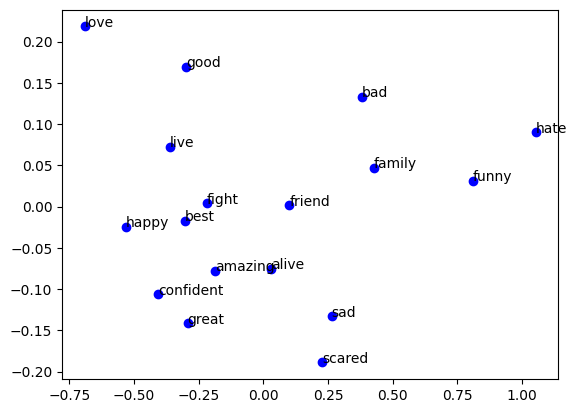

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf


# Perform PCA on embeddings
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings[0])
print(pca_embeddings.shape)

# Plot embeddings using matplotlib
fig, ax = plt.subplots()
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], marker='o', c='b')

for i, word in enumerate(words.split()):
    ax.annotate(word, (pca_embeddings[i, 0], pca_embeddings[i, 1]))
    
plt.show()